In [28]:
# globals
import numpy as np
from collections import defaultdict
from time import time
import matplotlib.pyplot as plt
import pandas as pd

# sklearn
from sklearn import metrics 
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.datasets import fetch_20newsgroups # importing dataset
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans


### Evaluating Function

In [5]:
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

this code block defines a function to call when evaluating the clustering algorithm. Because the experiment below uses labels, the function is able to use this to quantify the quality of the clusters. (typically this is a supervised method of evaluating.)

homegenity - measure of how much single class members each cluster has

completeness - measure on whether all members of a given class are assigned to the same cluster

V-measure - harmonic mean of homogenity and completeness

Adjusted Rand-Index - measures the similarity of the true labels and clustering labels and adjusted for chance. 

silouette coef - how close clusters are and how distinct they are  

### Code

In [6]:
dataset = fetch_20newsgroups(subset="all")

In [7]:
print(dataset.target_names) # printing all the categories

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [8]:
# defining topics
categories = [
    "comp.os.ms-windows.misc",
    "comp.sys.mac.hardware",
    "talk.politics.guns",
    "sci.space",
]

# taking away unwanted parts of the data this prevents classifiers overfitting on metadata 
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

# printing the number of documents and categories
labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3845 documents - 4 categories


In [9]:
vectorizer = TfidfVectorizer(
    max_df=0.5, # ignore terms that appear in more than 50% of docs
    min_df=5, # ignore terms that arent in at least 5 docs
    stop_words="english", # this removes common english dialect words such as "then, the, and etc"
)
t0 = time() # records the time of vectorisation
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.431 s
n_samples: 3845, n_features: 8397


TfidVectorizer uses an in-memory vocabulary to map most frequent words to features indices. 

n_features would contain the resulting number of unique terms after we used the parameters to cut down the search

In [10]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.006


The above quantifys the sparsity of the X_tfidf matrix as the fraction of non-zero entries / total no. of elements

In [11]:
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [   1 3816   26    2]
Number of elements assigned to each cluster: [   1 3842    1    1]
Number of elements assigned to each cluster: [ 630  787  542 1886]
Number of elements assigned to each cluster: [ 527 2411  406  501]
Number of elements assigned to each cluster: [   2    1    1 3841]

True number of documents in each category according to the class labels: [985 963 987 910]


In [12]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5, # increased number of runs with different centroid seeds
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors") # uses the evaluation function to evaluate the model


clustering done in 0.09 ± 0.02 s 
Homogeneity: 0.429 ± 0.016
Completeness: 0.497 ± 0.014
V-measure: 0.460 ± 0.015
Adjusted Rand-Index: 0.297 ± 0.024
Silhouette Coefficient: 0.009 ± 0.001


scores indicate moderate clustering quality

In [16]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.344 s
Explained variance of the SVD step: 18.4%


Latent Semantic Analysis (LSA) is a dimensionality reduction technique that uses singular value decomposition (SVD) to reduce the dimensionality of the TF-IDF vectors.

n-init=1 can still be used only if the vectorized space dimension is reduced first to make k-means more stable. 



In [20]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.05 ± 0.05 s 
Homogeneity: 0.521 ± 0.024
Completeness: 0.567 ± 0.012
V-measure: 0.543 ± 0.018
Adjusted Rand-Index: 0.436 ± 0.054
Silhouette Coefficient: 0.038 ± 0.003


LSA makes clustering perform much faster and the algorithm has improved.

In [22]:
minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.04 ± 0.03 s 
Homogeneity: 0.444 ± 0.121
Completeness: 0.530 ± 0.063
V-measure: 0.469 ± 0.086
Adjusted Rand-Index: 0.419 ± 0.140
Silhouette Coefficient: 0.027 ± 0.017


In [23]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: windows file dos files program thanks use using problem ftp 
Cluster 1: gun people fbi guns government don batf law did right 
Cluster 2: space like just think don nasa earth orbit launch time 
Cluster 3: mac apple drive thanks know does monitor problem card use 


inverting TfidfVectorizer to indentify cluster centres which provides intuition of the most influential words in each cluster. 

1. transform cluster centres back to original feature space using instance from lsa.

2. argsort is then used on the centroids to get the indices of the terms sorted by importance in descending order for each cluster. The slicing at the end of the line reverses the order so most important terms come first.

3. Vectorizer.get_fea... method retrieves the list of terms (features) from the vertorizer; which transformed the orignal text into a TF-IDF matrix. List of terms is then stored in the terms var.

4. the Code is then iterated over each cluster from 0 to true k minus 1. The first 10 indices in the order iterated over will print the corresponding terms from the list. 



In [25]:
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 1.406 s


Pipeline to process text through different transformers.

HashingVec - converts text data into matrix of token occurences, removes common english stop words and features set to 50000

TruncatedSVD - reduces dimenionality of TF-IDF matrix to 100 components (this will capture patterns yet reduce the complexity of the data)

Normalizer - resulting vectors are scaled to unit norm

In [26]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.08 ± 0.05 s 
Homogeneity: 0.518 ± 0.017
Completeness: 0.562 ± 0.002
V-measure: 0.539 ± 0.009
Adjusted Rand-Index: 0.439 ± 0.057
Silhouette Coefficient: 0.038 ± 0.001


In [27]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.05 ± 0.03 s 
Homogeneity: 0.444 ± 0.122
Completeness: 0.490 ± 0.070
V-measure: 0.463 ± 0.104
Adjusted Rand-Index: 0.400 ± 0.149
Silhouette Coefficient: 0.032 ± 0.006


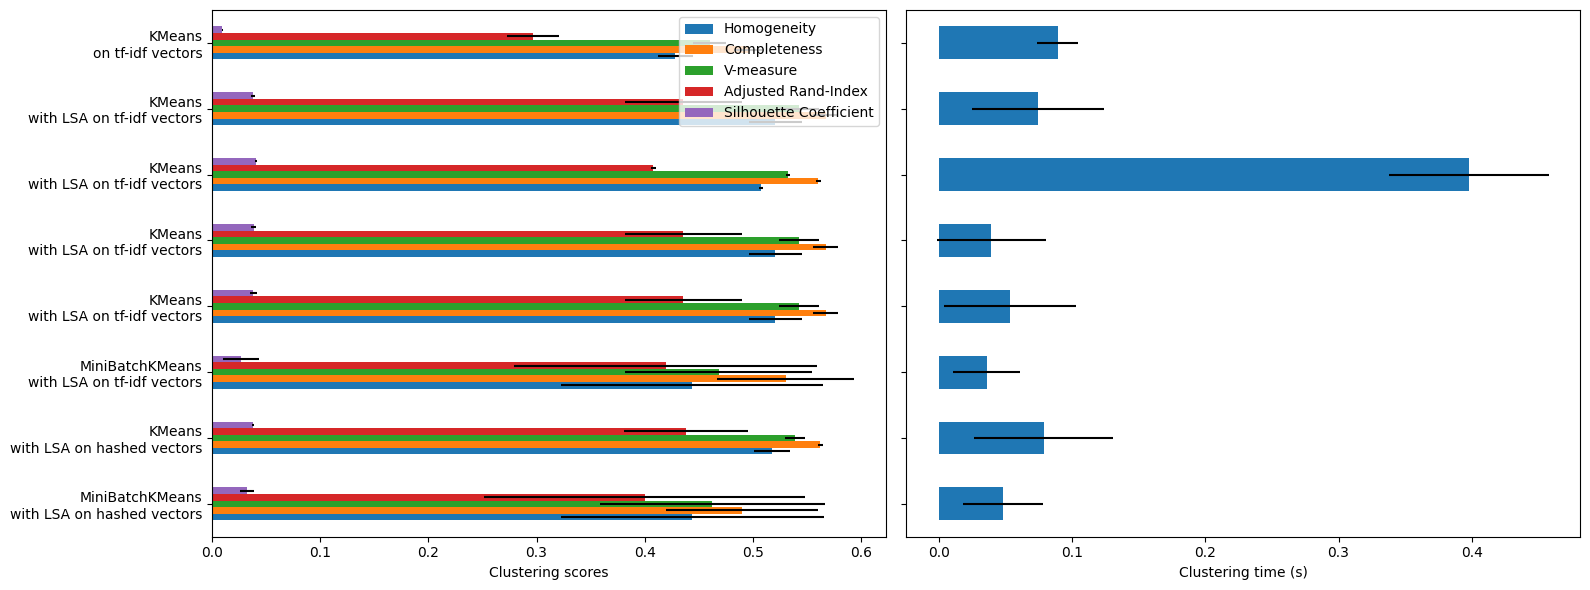

In [29]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()